# DAML - Least Squares

Michal Grochmal <michal.grochmal@city.ac.uk>

Linear regression can actually be solved analytically, that is unless we need to perform
`Ridge` or `Lasso` parameter filtering.  The analytical solution *is* what `sklearn` performs
when asked for a linear regression.  Here we will try to reach the least squares solution
from the scratch.

We measure the fit of a line to points by counting residuals,
these residuals are the distances of our data points to our model (line).

$$r^2 = \sum_{i=0}^{n} (y_i - (a_0 + a_1x_i))^2$$

Let's see how $r^2$ behaves when we change $a_0$ and/or $a_1$ for a group of points:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn
seaborn.set()

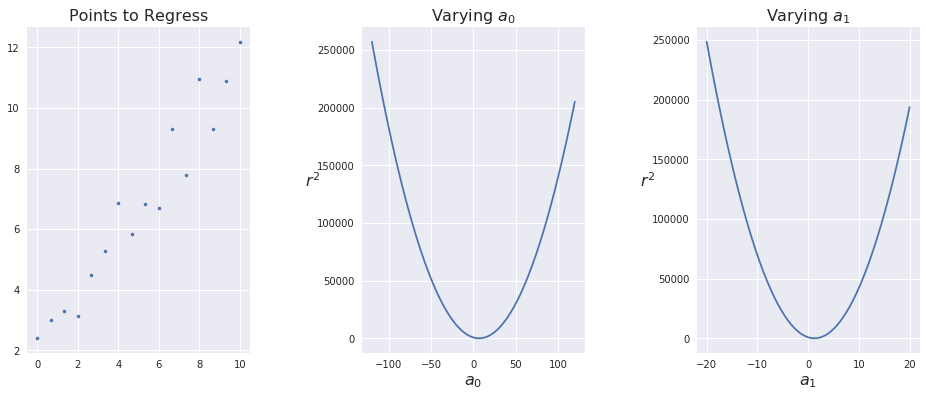

In [2]:
def residual(a0, a1, p):
    return np.sum((p[:, 0]*a1 + a0 - p[:, 1])**2)


scale_factor = 6  # just to scale plots to same size
x = np.linspace(0, 10, 16)
y = x + 3*np.random.rand(16)
points = np.array(list(zip(x, y)))
param_range = np.linspace(-20, 20, 100)
var_a0 = [residual(x, 0, points) for x in param_range*scale_factor]
var_a1 = [residual(0, x, points) for x in param_range]
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(wspace=0.5)
ax[0].plot(points[:, 0], points[:, 1], '.')
ax[0].set_title('Points to Regress', fontsize=16)
ax[1].plot(param_range*scale_factor, var_a0)
ax[1].set_title('Varying $a_0$', fontsize=16)
ax[1].set_xlabel('$a_0$', rotation=0, fontsize=16)
ax[1].set_ylabel('$r^2$', rotation=0, fontsize=16)
ax[2].plot(param_range, var_a1)
ax[2].set_title('Varying $a_1$', fontsize=16)
ax[2].set_xlabel('$a_1$', rotation=0, fontsize=16)
ax[2].set_ylabel('$r^2$', rotation=0, fontsize=16);

That makes sense, there is one best value for $a_0$ and one best value for $a_1$,
where best means the value that minimizes $r^2$.
And since $a_0$ and $a_1$ are independent of each other we can search for each value independently.

Since $r^2$ in both plots above can be understood as a function of both $a_0$ and $a_1$,
i.e. a 3-dimensional function.  We can have a look at it:

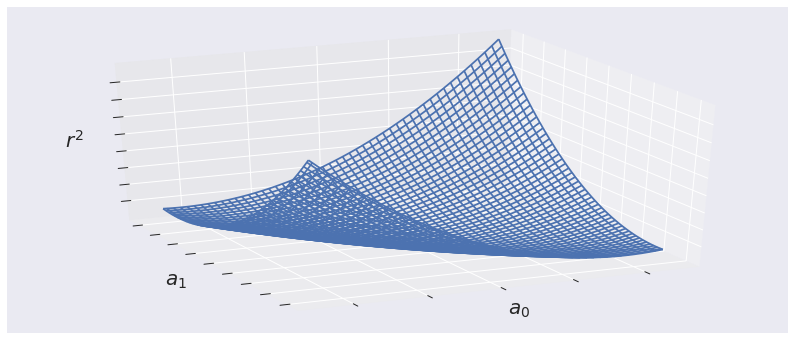

In [3]:
def grid_residual(xy):
    def build():
        for row in xy:
            for i in row:
                yield residual(i[0], i[1], points)
    return np.array(list(build()))


x, y = np.meshgrid(param_range*scale_factor, param_range)
xy = np.dstack([x, y])
z = grid_residual(xy).reshape(x.shape)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z)
ax.set_xlabel('$a_0$', fontsize=20)
ax.set_ylabel('$a_1$', fontsize=20)
ax.set_zlabel('$r^2$', fontsize=20)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.tick_params(axis='both', labelleft='off', labelbottom='off')
ax.view_init(elev=30., azim=65)

Good, we have the place where $r^2$ is minimal somewhere at the bottom of this shape.
Not that this is not necessarily $r^2 = 0$ but something as close to zero as possible.

Since we have a parabola-like surface with a bottom, and the bottom of a parabola is
characterized by a derivative equal to zero we can say that at the minimal possible
$R^2$ we have $\frac{\partial}{\partial a_0} r^2 = 0$ and
$\frac{\partial}{\partial a_1} r^2= 0$.  If we get a hold of the values of
$a_0$ and $a_1$ in this point we solved our least squares problem.

Let's differentiate against $a_0$:

$$
\frac{\partial (r^2)}{\partial a_0} =\\
\frac{\partial}{\partial a_0} \sum_{i=0}^{n} (y_i - (a_0 + a_1x_i))^2 =\\
\frac{\partial}{\partial a_0} \sum_{i=0}^{n} (y_i - a_0 - a_1x_i) \cdot (y_i - a_0 - a_1x_i) =\\
\frac{\partial}{\partial a_0} \sum_{i=0}^{n} y_i^2 - 2a_0y_i - 2a_1x_iy_i + 2a_0a_1x_i + a_0^2 + a_1^2x_i^2 =\\
\sum_{i=0}^{n} - 2y_i + 2a_1x_i + 2a_0 =\\
2 \cdot \left( \sum_{i=0}^{n} a_0 + \sum_{i=0}^{n} a_1x_i - \sum_{i=0}^{n} y_i \right) =\\
2 \cdot \left( na_0 + \sum_{i=0}^{n} a_1x_i - \sum_{i=0}^{n} y_i \right) = 0
$$

and $a_1$

$$
\frac{\partial (r^2)}{\partial a_1} =\\
\frac{\partial}{\partial a_1} \sum_{i=0}^{n} y_i^2 - 2a_0y_i - 2a_1x_iy_i + 2a_0a_1x_i + a_0^2 + a_1^2x_i^2 =\\
\sum_{i=0}^{n} - 2x_iy_i + 2a_0x_i + 2a_1x_i^2 =\\
2 \cdot \left( \sum_{i=0}^{n} a_0x_i + \sum_{i=0}^{n} a_1x_i^2 - \sum_{i=0}^{n} x_iy_i \right) = 0
$$

Since these equations equal zero we can simply drop the 2,
and we end with a set of two equation with two unknown variables:

$$
a_0n + a_1 \sum_{i=0}^{n} x_i = \sum_{i=0}^{n} y_i\\
a_0 \sum_{i=0}^{n} x_i + a_1 \sum_{i=0}^{n} x_i^2 = \sum_{i=0}^{n} x_iy_i
$$

These we can write at matrices and perform the Gaussian elimination to solve the set of equations:

$$
\begin{bmatrix}
    n & \sum_{i=0}^{n} x_i\\
    \sum_{i=0}^{n} x_i & \sum_{i=0}^{n} x_i^2
\end{bmatrix}
\begin{bmatrix}
    a_0\\
    a_1
\end{bmatrix}
=
\begin{bmatrix}
\sum_{i=0}^{n} y_i\\
\sum_{i=0}^{n} x_iy_i
\end{bmatrix}
$$

We multiply both sides by the inverse matrix:

$$
\begin{bmatrix}
    a_0\\
    a_1
\end{bmatrix}
=
\begin{bmatrix}
    n & \sum_{i=0}^{n} x_i\\
    \sum_{i=0}^{n} x_i & \sum_{i=0}^{n} x_i^2
\end{bmatrix}^{-1}
\begin{bmatrix}
    \sum_{i=0}^{n} y_i\\
    \sum_{i=0}^{n} x_iy_i
\end{bmatrix}
$$

Calculate the inverse matrix:
    
$$
\begin{bmatrix}
    a_0\\
    a_1
\end{bmatrix}
=
\frac{1}{n\sum_{i=0}^{n} x_i^2 - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_i}
\begin{bmatrix}
    \sum_{i=0}^{n} x_i^2 & -\sum_{i=0}^{n} x_i\\
    -\sum_{i=0}^{n} x_i & n
\end{bmatrix}
\begin{bmatrix}
    \sum_{i=0}^{n} y_i\\
    \sum_{i=0}^{n} x_iy_i
\end{bmatrix}
=\\
\frac{1}{n\sum_{i=0}^{n} x_i^2 - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_i}
\begin{bmatrix}
    \sum_{i=0}^{n} x_i^2  \sum_{i=0}^{n} y_i - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_iy_i\\
    n \sum_{i=0}^{n} x_iy_i -\sum_{i=0}^{n} x_i \sum_{i=0}^{n} y_i
\end{bmatrix}
$$

Now we have independent equations for both $a_0$ and $a_1$:

$$
a_0 = \frac{\sum_{i=0}^{n} x_i^2  \sum_{i=0}^{n} y_i - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_iy_i}
{n \sum_{i=0}^{n} x_i^2 - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_i}\\
a_1 = \frac{n \sum_{i=0}^{n} x_iy_i - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} y_i}
{n \sum_{i=0}^{n} x_i^2 - \sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_i}
$$

And since $\frac{\sum_{i=0}^{n} x_i}{n} = \overline{x}$ we can simplify this by dividing
both parts of each fraction by $n$:

$$
a_0 = \frac{\overline{y} \sum_{i=0}^{n} x_i^2 - \overline{x} \sum_{i=0}^{n} x_iy_i}
{\sum_{i=0}^{n} x_i^2 - \overline{x} \sum_{i=0}^{n} x_i}\\
a_1 = \frac{\sum_{i=0}^{n} x_iy_i - \overline{x} \sum_{i=0}^{n} y_i}
{\sum_{i=0}^{n} x_i^2 - \overline{x} \sum_{i=0}^{n} x_i}
$$

If we cleverly select a couple of elements and divide them by $n$
again we can simplify further:

$$
a_0 = \frac{\overline{y} \sum_{i=0}^{n} x_i^2 - \overline{x} \sum_{i=0}^{n} x_iy_i}
{\sum_{i=0}^{n} x_i^2 - n \overline{x}^2}\\
a_1 = \frac{\sum_{i=0}^{n} x_iy_i - n \overline{x} \overline{y}}
{\sum_{i=0}^{n} x_i^2 - n \overline{x}^2}
$$

Finally we have rather usable equations to solve least squares.
The same can be performed for 3-dimensions or more but the number of equations
grows geometrically because the calculation of the inverse matrix is quite complex
as we add more and more dimensions.  Good thing we have computers.